# Image classification transfer learning demo

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
3. [Fine-tuning the Image classification model](#Fine-tuning-the-Image-classification-model)
4. [Training parameters](#Training-parameters)
5. [Start the training](#Start-the-training)
6. [Inference](#Inference)


## Introduction

Welcome to our end-to-end example of distributed image classification algorithm in transfer learning mode. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [2]:
!jupyter labextension list

JupyterLab v1.2.21
No installed extensions


In [13]:
!pip install ipywidgets

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [7]:
!conda install -y -c conda-forge nodejs==10.13.0

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - nodejs==10.13.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    nodejs-10.13.0             |       he6710b0_0        13.0 MB
    ------------------------------------------------------------
                                           Total:        13.0 MB

The following packages will be UPDATED:

  nodejs                       conda-forge::nodejs-6.13.1-0 --> pkgs/main::nodejs-10.13.0-he6710b0_0



nodejs-10.13.0       | 13.0 MB   | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [8]:
!jupyter lab clean


[LabCleanApp] Cleaning /opt/conda/share/jupyter/lab...
[LabCleanApp] Success!


In [9]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager


Building jupyterlab assets (build:prod:minimize)


In [4]:
!cat /tmp/jupyterlab-debug-kxwy1ktj.log


Yarn configuration loaded.
Node v6.13.1

> /opt/conda/bin/npm pack @jupyter-widgets/jupyterlab-manager
jupyter-widgets-jupyterlab-manager-3.0.1.tgz

Fetching URL: https://registry.yarnpkg.com/@jupyter-widgets%2Fjupyterlab-manager
> /opt/conda/bin/npm pack @jupyter-widgets/jupyterlab-manager@1.1.0
jupyter-widgets-jupyterlab-manager-1.1.0.tgz

Fetching URL: https://registry.yarnpkg.com/@jupyter-widgets%2Fjupyterlab-manager
> /opt/conda/bin/npm pack @jupyter-widgets/jupyterlab-manager@1.1.0
jupyter-widgets-jupyterlab-manager-1.1.0.tgz

Incompatible extension:
@jupyter-widgets/jupyterlab-manager
Found compatible version: 1.1.0
> /opt/conda/bin/npm pack @jupyter-widgets/jupyterlab-manager@1.1.0
jupyter-widgets-jupyterlab-manager-1.1.0.tgz

Yarn configuration loaded.
Node v6.13.1

Building jupyterlab assets (build:prod:minimize)
> node /opt/conda/lib/python3.7/site-packages/jupyterlab/staging/yarn.js install --non-interactive
yarn install v1.15.2
[1/5] Validating package.json...
[2/5] Resolv

In [2]:
%%time
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

region = boto3.Session().region_name

s3_client = boto3.client("s3")

sess = sagemaker.Session()
data_bucket = f"sagemaker-sample-files"
data_prefix = "datasets/image/caltech-256/"

output_bucket = sess.default_bucket()
output_prefix = "ic-transfer-learning"

s3_client.download_file(
    data_bucket, data_prefix + "caltech-256-60-train.rec", "caltech-256-60-train.rec"
)
s3_client.download_file(
    data_bucket, data_prefix + "caltech-256-60-val.rec", "caltech-256-60-val.rec"
)
s3_client.upload_file(
    "caltech-256-60-train.rec", output_bucket, output_prefix + "/train_rec/caltech-256-60-train.rec"
)
s3_client.upload_file(
    "caltech-256-60-train.rec",
    output_bucket,
    output_prefix + "/validation_rec/caltech-256-60-train.rec",
)

arn:aws:iam::452533547478:role/service-role/AmazonSageMaker-ExecutionRole-20210709T125430
CPU times: user 7.5 s, sys: 7.04 s, total: 14.5 s
Wall time: 32.7 s


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, "image-classification", repo_version="latest")
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/image-classification:1


## Fine-tuning the Image classification model

The caltech 256 dataset [1] consist of images from 257 categories (the last one being a clutter category) and has 30k images with a minimum of 80 images and a maximum of about 800 images per category. 

The image classification algorithm can take two types of input formats. The first is a [recordio format](https://mxnet.incubator.apache.org/faq/recordio.html) and the other is a [lst format](https://mxnet.incubator.apache.org/faq/recordio.html?highlight=im2rec). Files for both these formats are available at http://data.dmlc.ml/mxnet/data/caltech-256/. In this example, we will use the recordio format for training and use the training/validation split [specified here](http://data.dmlc.ml/mxnet/data/caltech-256/). 

Data in this notebook was downloaded from [MXNet's caltech-256 training dataset](http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec) and [MXNet's caltech-256 validation dataset](http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec) and stored in the `data_bucket`.

>[1] Griffin, G. Holub, AD. Perona, P. The Caltech 256. Caltech Technical Report.

In [4]:
import boto3

# Four channels: train, validation, train_lst, and validation_lst
s3train = f"s3://{output_bucket}/{output_prefix}/train_rec/"
s3validation = f"s3://{output_bucket}/{output_prefix}/validation_rec/"

Once we have the data available in the correct format for training, the next step is to actually train the model using the data. Before training the model, we need to setup the training parameters. The next section will explain the parameters in detail.

## Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored

In [5]:
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"
ic = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p2.xlarge",
    train_volume_size=50,
    train_max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sess,
)

train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode


In [6]:
ic.set_hyperparameters(
    num_layers=18,
    use_pretrained_model=1,
    image_shape="3,224,224",
    num_classes=257,
    num_training_samples=15420,
    mini_batch_size=128,
    epochs=2,
    learning_rate=0.01,
    precision_dtype="float32",
)

## Input data specification
Set the data type and channels used for training

In [7]:
train_data = sagemaker.session.s3_input(
    s3train,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.session.s3_input(
    s3validation,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## Start the training
Start training by calling the fit method in the estimator

In [8]:
%%time

ic.fit(inputs=data_channels, logs=True)

2022-02-08 03:25:04 Starting - Starting the training job...
2022-02-08 03:25:28 Starting - Launching requested ML instancesProfilerReport-1644290704: InProgress
......
2022-02-08 03:26:28 Starting - Preparing the instances for training.........
2022-02-08 03:27:54 Downloading - Downloading input data...
2022-02-08 03:28:28 Training - Downloading the training image......
2022-02-08 03:29:37 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[02/08/2022 03:29:41 INFO 139725424961344] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[02/08/2022 03:29:41

# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the class of the image. You can deploy the created model by using the deploy method in the estimator

In [9]:
ic_classifier = ic.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------!

### List of object categories

In [10]:
object_categories = [
    "ak47",
    "american-flag",
    "backpack",
    "baseball-bat",
    "baseball-glove",
    "basketball-hoop",
    "bat",
    "bathtub",
    "bear",
    "beer-mug",
    "billiards",
    "binoculars",
    "birdbath",
    "blimp",
    "bonsai-101",
    "boom-box",
    "bowling-ball",
    "bowling-pin",
    "boxing-glove",
    "brain-101",
    "breadmaker",
    "buddha-101",
    "bulldozer",
    "butterfly",
    "cactus",
    "cake",
    "calculator",
    "camel",
    "cannon",
    "canoe",
    "car-tire",
    "cartman",
    "cd",
    "centipede",
    "cereal-box",
    "chandelier-101",
    "chess-board",
    "chimp",
    "chopsticks",
    "cockroach",
    "coffee-mug",
    "coffin",
    "coin",
    "comet",
    "computer-keyboard",
    "computer-monitor",
    "computer-mouse",
    "conch",
    "cormorant",
    "covered-wagon",
    "cowboy-hat",
    "crab-101",
    "desk-globe",
    "diamond-ring",
    "dice",
    "dog",
    "dolphin-101",
    "doorknob",
    "drinking-straw",
    "duck",
    "dumb-bell",
    "eiffel-tower",
    "electric-guitar-101",
    "elephant-101",
    "elk",
    "ewer-101",
    "eyeglasses",
    "fern",
    "fighter-jet",
    "fire-extinguisher",
    "fire-hydrant",
    "fire-truck",
    "fireworks",
    "flashlight",
    "floppy-disk",
    "football-helmet",
    "french-horn",
    "fried-egg",
    "frisbee",
    "frog",
    "frying-pan",
    "galaxy",
    "gas-pump",
    "giraffe",
    "goat",
    "golden-gate-bridge",
    "goldfish",
    "golf-ball",
    "goose",
    "gorilla",
    "grand-piano-101",
    "grapes",
    "grasshopper",
    "guitar-pick",
    "hamburger",
    "hammock",
    "harmonica",
    "harp",
    "harpsichord",
    "hawksbill-101",
    "head-phones",
    "helicopter-101",
    "hibiscus",
    "homer-simpson",
    "horse",
    "horseshoe-crab",
    "hot-air-balloon",
    "hot-dog",
    "hot-tub",
    "hourglass",
    "house-fly",
    "human-skeleton",
    "hummingbird",
    "ibis-101",
    "ice-cream-cone",
    "iguana",
    "ipod",
    "iris",
    "jesus-christ",
    "joy-stick",
    "kangaroo-101",
    "kayak",
    "ketch-101",
    "killer-whale",
    "knife",
    "ladder",
    "laptop-101",
    "lathe",
    "leopards-101",
    "license-plate",
    "lightbulb",
    "light-house",
    "lightning",
    "llama-101",
    "mailbox",
    "mandolin",
    "mars",
    "mattress",
    "megaphone",
    "menorah-101",
    "microscope",
    "microwave",
    "minaret",
    "minotaur",
    "motorbikes-101",
    "mountain-bike",
    "mushroom",
    "mussels",
    "necktie",
    "octopus",
    "ostrich",
    "owl",
    "palm-pilot",
    "palm-tree",
    "paperclip",
    "paper-shredder",
    "pci-card",
    "penguin",
    "people",
    "pez-dispenser",
    "photocopier",
    "picnic-table",
    "playing-card",
    "porcupine",
    "pram",
    "praying-mantis",
    "pyramid",
    "raccoon",
    "radio-telescope",
    "rainbow",
    "refrigerator",
    "revolver-101",
    "rifle",
    "rotary-phone",
    "roulette-wheel",
    "saddle",
    "saturn",
    "school-bus",
    "scorpion-101",
    "screwdriver",
    "segway",
    "self-propelled-lawn-mower",
    "sextant",
    "sheet-music",
    "skateboard",
    "skunk",
    "skyscraper",
    "smokestack",
    "snail",
    "snake",
    "sneaker",
    "snowmobile",
    "soccer-ball",
    "socks",
    "soda-can",
    "spaghetti",
    "speed-boat",
    "spider",
    "spoon",
    "stained-glass",
    "starfish-101",
    "steering-wheel",
    "stirrups",
    "sunflower-101",
    "superman",
    "sushi",
    "swan",
    "swiss-army-knife",
    "sword",
    "syringe",
    "tambourine",
    "teapot",
    "teddy-bear",
    "teepee",
    "telephone-box",
    "tennis-ball",
    "tennis-court",
    "tennis-racket",
    "theodolite",
    "toaster",
    "tomato",
    "tombstone",
    "top-hat",
    "touring-bike",
    "tower-pisa",
    "traffic-light",
    "treadmill",
    "triceratops",
    "tricycle",
    "trilobite-101",
    "tripod",
    "t-shirt",
    "tuning-fork",
    "tweezer",
    "umbrella-101",
    "unicorn",
    "vcr",
    "video-projector",
    "washing-machine",
    "watch-101",
    "waterfall",
    "watermelon",
    "welding-mask",
    "wheelbarrow",
    "windmill",
    "wine-bottle",
    "xylophone",
    "yarmulke",
    "yo-yo",
    "zebra",
    "airplanes-101",
    "car-side-101",
    "faces-easy-101",
    "greyhound",
    "tennis-shoes",
    "toad",
    "clutter",
]

### Download test image

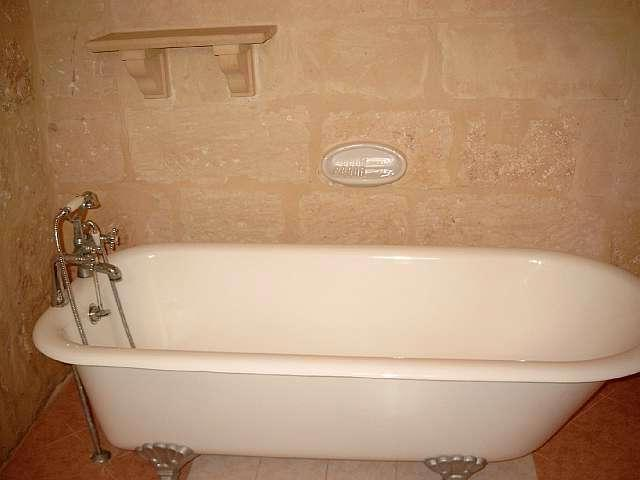

In [11]:
# test image
file_name = "/tmp/test.jpg"
s3_client.download_file(
    "sagemaker-sample-files",
    "datasets/image/caltech-256/256_ObjectCategories/008.bathtub/008_0007.jpg",
    file_name,
)

from IPython.display import Image

Image(file_name)

### Evaluation

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.

**Note:** The output class detected by the network may not be accurate in this example. To limit the time taken and cost of training, we have trained the model only for a couple of epochs. If the network is trained for more epochs (say 20), then the output class will be more accurate.

In [15]:
import json
import numpy as np

file_name = './shoes.jpeg'

with open(file_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

# Invoke the deployed model to compute prediction
prediction = ic_classifier.predict(payload, initial_args={"ContentType": "application/x-image"})

# prediction is a JSON string. Load it into a Python object.
probabilities = json.loads(prediction)

# find the class with maximum probability and print the class index
predicted_category_index = np.argmax(probabilities)
predicted_category_name = object_categories[predicted_category_index]
confidence = probabilities[predicted_category_index]

print(f"Result: label -  {predicted_category_name}, probability - {confidence}")

Result: label -  sneaker, probability - 0.4979841709136963


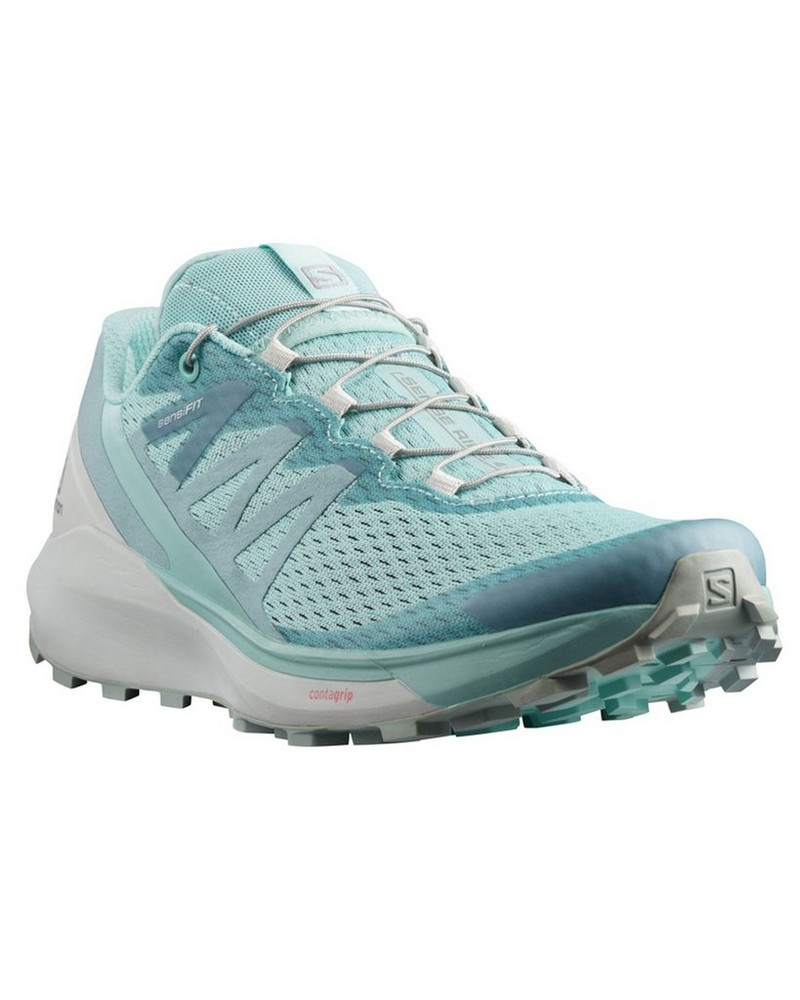

In [14]:
file = './shoes.jpeg'

Image(file)

In [ ]:
from ipywidgets import FileUpload
from IPython.display import display
upload = FileUpload(accept='*.*', multiple=True)
display(upload)


In [ ]:
upload.data[0]

### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
ic_classifier.delete_endpoint()